In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

rd = pd.read_excel('./Resources/combined_phecodex_list.xlsx')
cd = rd.loc[rd['Type'] == 'Common']

from statsmodels.stats.proportion import proportion_confint
from scipy.stats import ranksums

import seaborn as sns
from matplotlib import pyplot as plt
from upsetplot import UpSet

# Optional plotting function
if True:
    import re
    import os
    import matplotlib
    import matplotlib.font_manager as font_manager

    font_path = '/sc/arion/projects/GENECAD/Robert/arial.ttf'
    assert os.path.exists(font_path)
    font_manager.fontManager.addfont(font_path)
    prop = font_manager.FontProperties(fname=font_path)

    matplotlib.rc('font', family='sans-serif')
    matplotlib.rcParams.update({
        'font.size': 12,
        'font.sans-serif': prop.get_name(),
        'axes.titlesize': 12
    })


In [4]:
alldata = pd.read_pickle('./Final/ml_input.pkl')

clin = ['clingen','eva','gene2phenotype','genomics_england','orphanet','uniprot_literature', 'uniprot_variants','omim']
ot = ['clin_ot','hgmd','gwas_credible_sets','expression_atlas','impc','europepmc']
ot_all = ['clin_ot','hgmd','omim','gene_burden','gwas_credible_sets','cancer_gene_census','eva_somatic','reactome','expression_atlas','impc','europepmc']
mantis = ['mantis']
cc = ['cc_common_max_p','cc_rare_max_p','cc_rare_burden_max_p','cc_ultrarare_max_p']

min1 = alldata.loc[alldata[ot+mantis+cc].max(axis=1) > 0]
nps = alldata.loc[(alldata[['clin_ot','hgmd','omim']].max(axis=1) == 0)]


## Top hits

In [5]:
pred = pd.read_pickle('./GPS/Main/Predictions/apc_predictions_ot_mantis_cc.pkl').sort_values('prediction', ascending=False)
pred = pred.loc[pred['id'].isin(min1['id'])]
pred = pred.merge(rd[['phecode','phecode_string']])
pred = pred.merge(alldata[['id','drug_gene','Tclin']])
ao = pd.read_pickle('./AMELIE/amelie_output_aggregated.pkl')[['gene','phecode','score']].rename({'score':'amelie'},axis=1)
pred = pred.merge(ao, how='left')

tn = pd.read_pickle('./Resources/targets_with_names_cleaned.pkl').sort_values(['gene','dc_name'])
tn = tn.groupby(['gene','moa'])['dc_name'].unique().reset_index()
tn['dc_name'] = tn['dc_name'].astype(str)
tn['dc_name'] = tn['dc_name'].str.replace("' '",", ",regex=False).str.replace("['","",regex=False).str.replace("']","",regex=False)
tn = pd.pivot(tn, index='gene', columns='moa', values='dc_name').reset_index()
pred = pred.merge(tn, on='gene', how='left')


In [6]:
t1 = pred.loc[pred['prediction'] >= 0.036805]
print(len(t1), t1['phecode'].nunique(), t1['gene'].nunique())

a = t1['Tclin'].dropna()
b = pred.loc[~pred['id'].isin(t1['id'])]['Tclin'].dropna()

print(a.median(), b.median(), ranksums(a,b))
print(len(t1.loc[(t1['Tclin'] > 0.5) | (t1['drug_gene'] == 1)]))

tf = alldata[['id']+ot+mantis+cc]
tf = tf.loc[tf['id'].isin(t1['id'])]
for col in cc:
    tf.loc[tf[col] < 1.301, col] = np.nan
for col in ot+mantis:
    tf.loc[tf[col] < 0.001, col] = np.nan
tf = tf.set_axis(['id','OTP clinical genetics','HGMD','Locus2gene','Gene expression','Mouse models',
                  'Text mining','Mantis-ML','Common variants','Rare variants',
                  'Rare variants (gene-level)','Ultra-rare variants (gene-level)'],axis=1)
tf['Support'] = tf.apply(lambda row: sorted([col for col in tf.columns if col != 'id' and not pd.isna(row[col])]), axis=1)
tf = tf[['id','Support']]


12275 124 4658
0.0152 0.001 RanksumsResult(statistic=np.float64(85.56297229560641), pvalue=np.float64(0.0))
6411


### Sources of evidence

In [7]:
features = ['OTP clinical genetics','HGMD','L2G','Gene expression','Mouse models',
                  'Text mining','Mantis-ML','Common variants','Rare variants',
                  'Rare variants (gene-level)','Ultra-rare variants (gene-level)']
ga = ['Common variants','Rare variants','Rare variants (gene-level)','Ultra-rare variants (gene-level)']
merged = ['Clinical genetics','Genetic associations','Gene expression','Mouse models','Text mining','Mantis-ML']

fs = alldata[['id']+ot+mantis+cc]
for col in cc:
    fs.loc[fs[col] < 1.301, col] = 0
    fs.loc[fs[col] > 0, col] = 1
for col in ot+mantis:
    fs.loc[fs[col] < 0.001, col] = 0
    fs.loc[fs[col] > 0, col] = 1
fs = fs.set_axis(['id']+features,axis=1)
fs = t1[['id']].merge(fs, on='id')
fs['Clinical genetics'] = fs[['OTP clinical genetics','HGMD']].max(axis=1)
fs['Common variants'] = fs[['L2G','Common variants']].max(axis=1)
fs['Genetic associations'] = fs[['L2G'] + ga].max(axis=1)
fs.loc[:, fs.columns != 'id'] = fs.loc[:, fs.columns != 'id'] > 0

fs_merged = fs.groupby(merged)['id'].nunique()
fs_merged = pd.DataFrame(fs_merged)

fs_ga = fs.groupby(ga)['id'].nunique()
fs_ga = pd.DataFrame(fs_ga)


In [8]:
print(len(fs.loc[fs[merged].sum(axis=1) > 1]))
print(len(fs.loc[fs[merged].sum(axis=1) > 2]))

10520
5989


{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

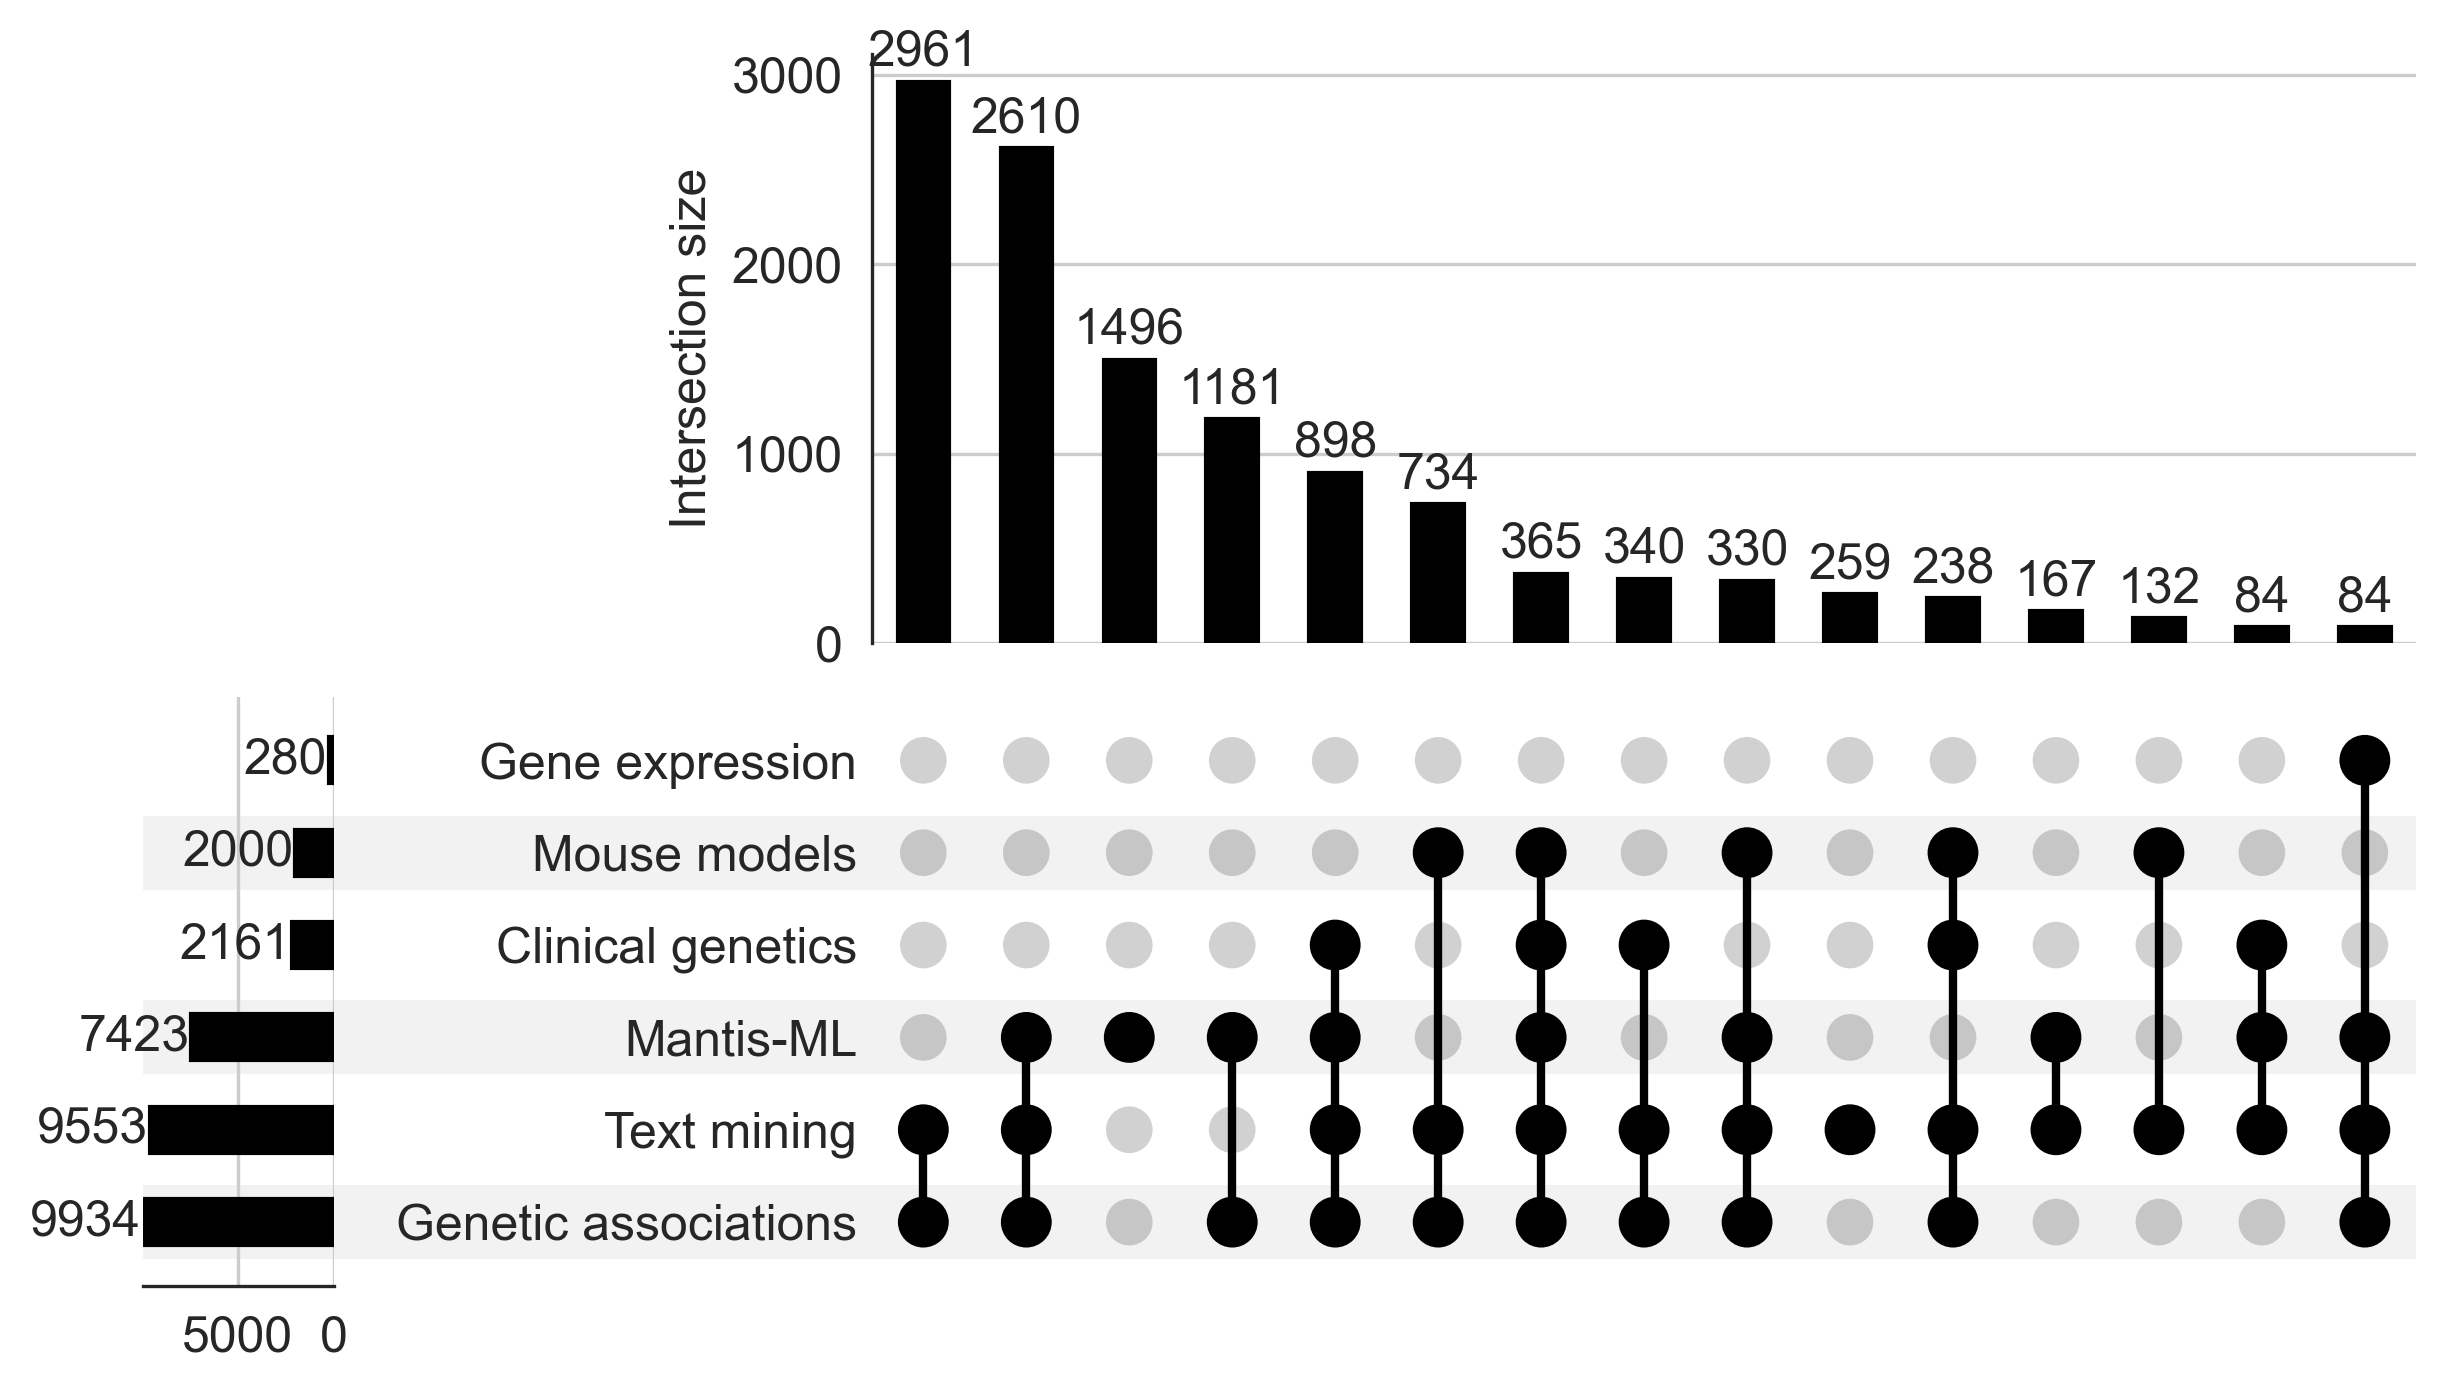

In [9]:
fig = plt.figure(figsize=(8, 4), dpi=300)
sns.set_style('white')

upset = UpSet(fs_merged, sum_over='id', subset_size='sum', min_subset_size=66, sort_by="cardinality", show_counts=True)
upset.plot(fig=fig)


{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

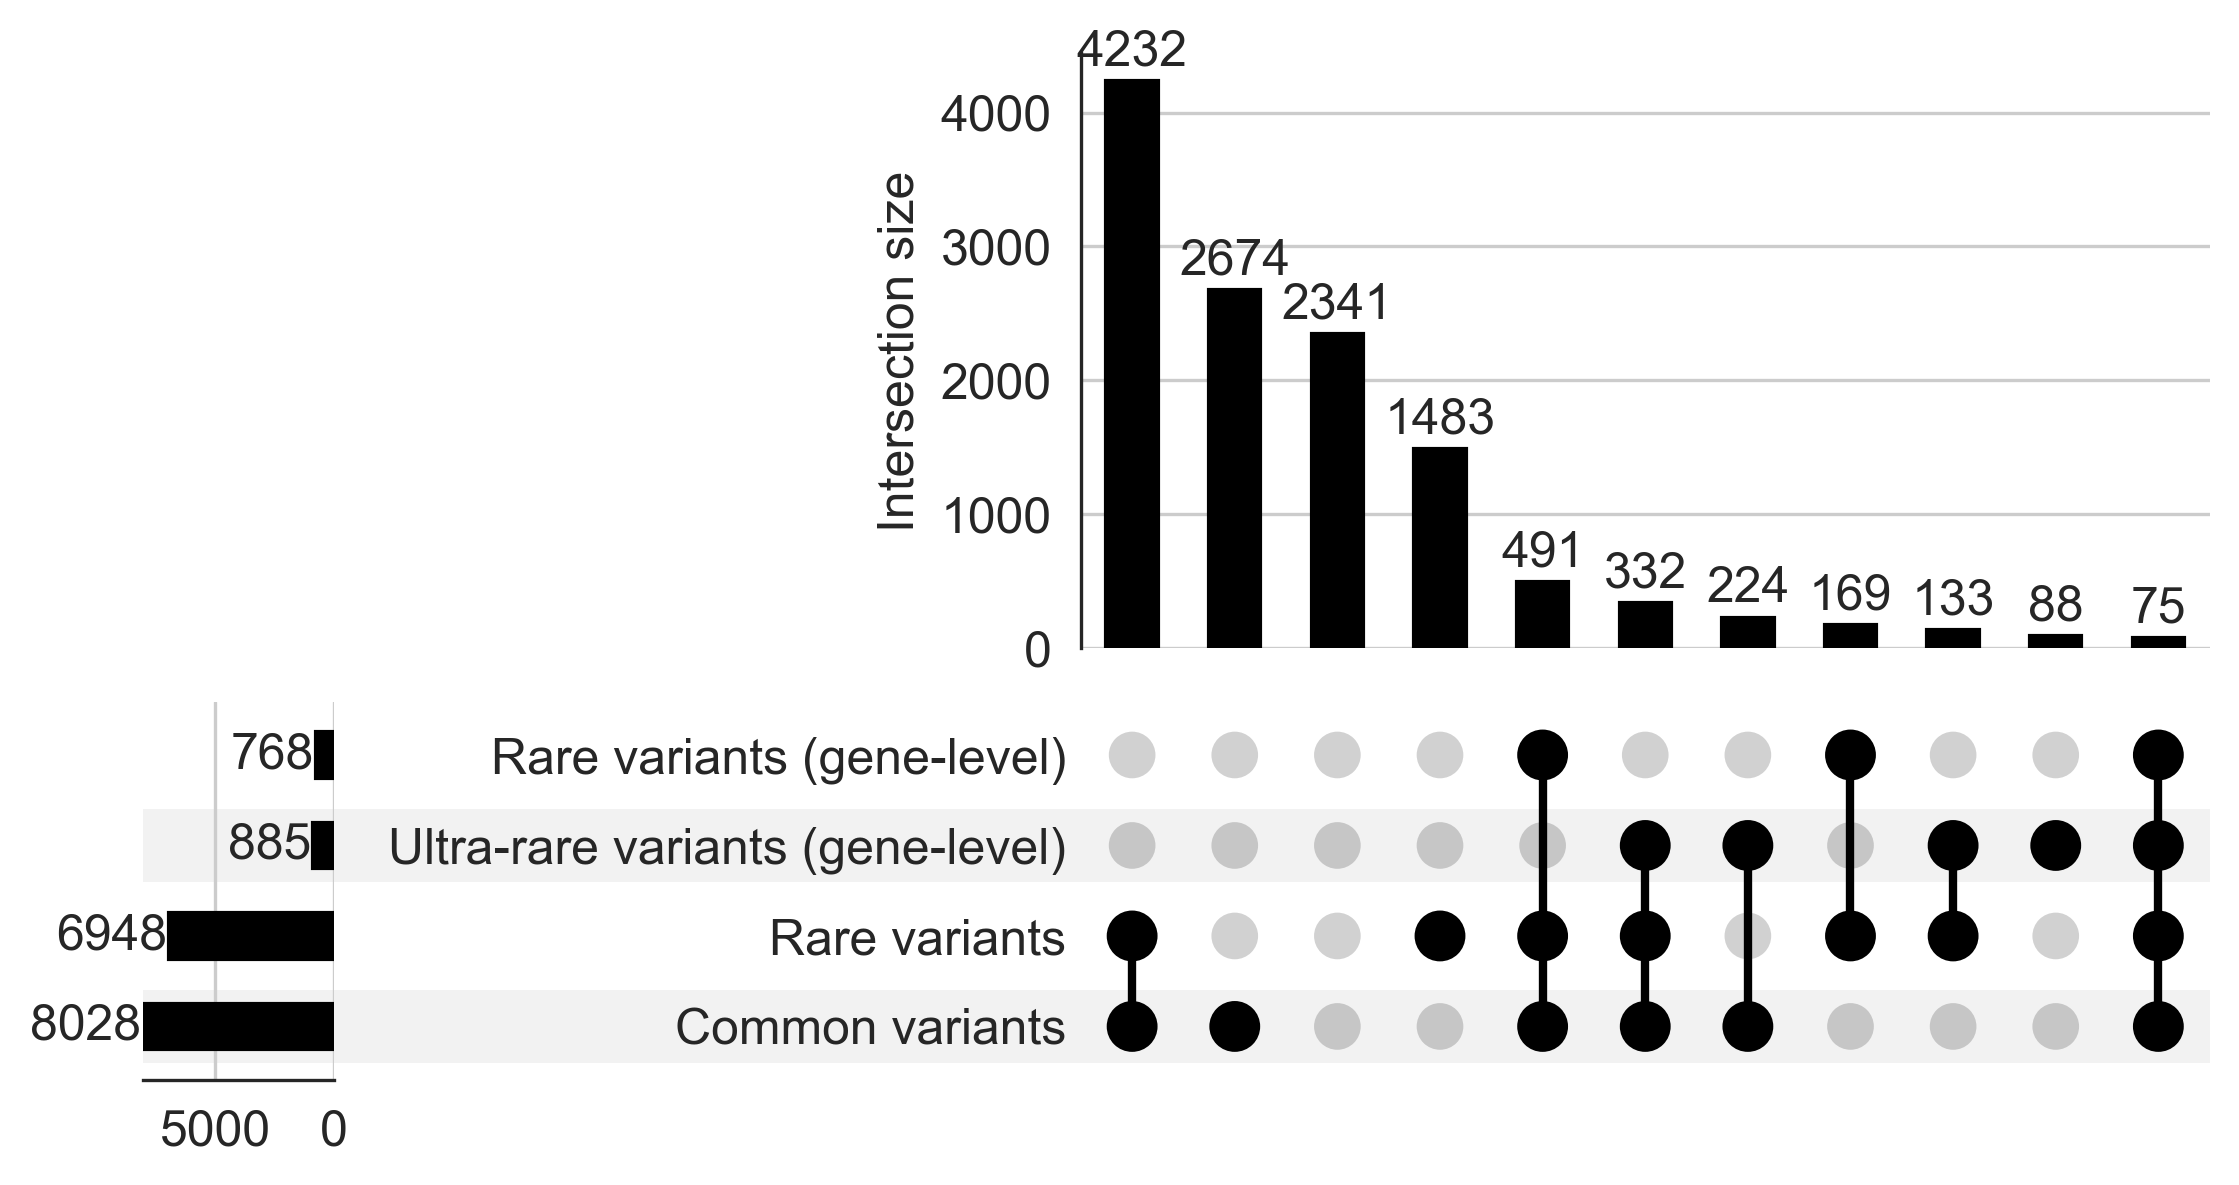

In [10]:
fig = plt.figure(figsize=(8, 4), dpi=300)
sns.set_style('white')

upset = UpSet(fs_ga, sum_over='id', subset_size='sum', min_subset_size=50, sort_by="cardinality", show_counts=True)
upset.plot(fig=fig)


### Use case #1

In [34]:
nd = t1.loc[(t1['indication'] == 0) & (t1['drug_gene'] == 1)]
nd = nd[nd[['Negative modulator', 'Other', 'Positive modulator']].notna().any(axis=1)]
print(len(nd))

3492


### Use case #2

In [21]:
tn = pd.read_pickle('./Resources/targets_with_names_cleaned.pkl')
trials = pd.read_pickle('./Resources/all_trials.pkl')
trials = trials.loc[trials['active'] == 1]
trials = trials.loc[trials['phase'] < 4]
trials = trials.loc[trials['study_id'].notna()]
study_ids = trials.groupby(['id','phase'])['study_id'].unique().reset_index()
trials = trials.merge(tn[['chembl_id','dc_name']].drop_duplicates('chembl_id'), on='chembl_id', how='left')
trials = trials.groupby(['id','phase'])['dc_name'].unique().reset_index()

active = pred.merge(trials, on=['id','phase'])
print(active['id'].nunique())

an = active.loc[active['id'].isin(nps['id'])]

tf = alldata[['id']+ot+mantis+cc]
tf = tf.loc[tf['id'].isin(an['id'])]
for col in cc:
    tf.loc[tf[col] < 1.301, col] = np.nan
for col in ot+mantis:
    tf.loc[tf[col] < 0.001, col] = np.nan
tf = tf.set_axis(['id','OTP clinical genetics','HGMD','L2G','Gene expression','Mouse models',
                  'Text mining','Mantis-ML','Common variants','Rare variants',
                  'Rare variants (gene-level)','Ultra-rare variants (gene-level)'],axis=1)
tf['Support'] = tf.apply(lambda row: sorted([col for col in tf.columns if col != 'id' and not pd.isna(row[col])]), axis=1)
tf = tf[['id','Support']]

an = an.merge(tf, how='left')
an['dc_name'] = an['dc_name'].astype(str).str.replace(" 'Unknown'","").str.replace("'","").str.replace(" ",", ").str.replace("[","").str.replace("]","")
an = an.merge(study_ids, how='left')
an = an.loc[an['prediction'] > 0.036805]
print(len(an))

802
63


In [23]:
an[:10]

,id,prediction,gene,phecode,indication,phase,xscore,phecode_string,drug_gene,Tclin,amelie,Negative modulator,Other,Positive modulator,dc_name,Support,study_id
0,CV_433.3:PDE3A,0.129632,PDE3A,CV_433.3,1,3.0,0.732000,Cerebrovascular insufficiency,1,0.9973,100.000000,"aminophylline, amrinone, anagrelide, cilostazo...",NaN,NaN,cilostazol,"[Common variants, L2G, Mantis-ML, Rare variant...","[NCT06242145, NCT06242132, NCT06196047, NCT062..."
1,GU_580.52:AGTR1,0.107991,AGTR1,GU_580.52,1,3.0,0.732000,Diffuse membranous glomerulonephritis,1,0.9956,NaN,"azilsartan, azilsartan kamedoxomil, azilsartan...",NaN,angiotensin ii,"sparsentan, irbesartan","[Common variants, Mouse models, Text mining, U...",[NCT03493685]
2,NS_323.3:GSK3B,0.093997,GSK3B,NS_323.3,1,3.0,0.732000,Motor neuron disease,1,0.9378,37.264653,"azd-1080, elraglusib, lithium, lithium anhydro...",NaN,NaN,lithium,"[Common variants, Mantis-ML, Text mining]",[NCT06008249]
3,MS_700.3:TYK2,0.090036,TYK2,MS_700.3,1,2.0,0.401136,Systemic sclerosis,1,0.9880,NaN,3-(cyanomethyl)-3-(4-(6-(1-methylpyrazol-4-yl)...,NaN,NaN,nan,"[L2G, Rare variants, Text mining]",[NCT06044844]
4,CV_433.3:F8,0.087950,F8,CV_433.3,1,3.0,0.732000,Cerebrovascular insufficiency,1,0.9000,100.000000,"drotrecogin, drotrecogin (activated), tb-402","antihemophilic factor,'\n 'antihemophilic fact...",NaN,"drotrecogin, , (activated)","[L2G, Mantis-ML, Rare variants, Rare variants ...",[NCT05484154]
5,MS_727.5:TNFSF11,0.083518,TNFSF11,MS_727.5,1,2.0,0.401136,Cyst of bone,1,0.9984,35.744243,"denosumab, lenalidomide",NaN,NaN,denosumab,"[Common variants, Mouse models, Rare variants,...",[NCT05419050]
6,GE_978.3:SOST,0.081308,SOST,GE_978.3,1,3.0,0.732000,Osteochondrodysplasias,1,0.2692,100.000000,"amg-167, anti-sclerostin, blosozumab, romosozu...",NaN,NaN,"setrusumab, romosozumab","[Common variants, Mouse models, Text mining]","[NCT05768854, NCT05972551]"
7,GE_973.5:DRD2,0.080381,DRD2,GE_973.5,1,3.0,0.732000,Huntington's disease,1,0.9993,NaN,"1-(2,3-dihydro-1,4-benzodioxin-5-yl)-4-((5-(4-...","3-carbamoyl-n,n-diethyl-1,3,4,6,7,11b-hexahydr...","(6ar,9r,10ar)-n-[(1s,2s,4r,7s)-7-benzyl-2-hydr...",pridopidine,"[Common variants, Mouse models, Rare variants,...",[NCT04556656]
8,NS_323.3:IL2RB,0.073654,IL2RB,NS_323.3,1,2.0,0.401136,Motor neuron disease,1,0.9962,8.902127,"basiliximab, daclizumab, humik-beta-1, mik-beta-1","denileukin diftitox, simlukafusp","aldesleukin, interleukin-15, pegenzileukin",aldesleukin,"[Common variants, Mantis-ML, Rare variants, Te...","[NCT04952155, NCT04055623]"
9,MS_727.5:FGF23,0.069254,FGF23,MS_727.5,1,2.0,0.401136,Cyst of bone,1,0.7954,71.652222,burosumab,NaN,NaN,burosumab,"[Mouse models, Rare variants, Text mining]",[NCT05509595]


### Use case #3

In [27]:
gi = t1.loc[(t1['indication'] == 0)]
gi[:20]


,id,prediction,gene,phecode,indication,phase,xscore,phecode_string,drug_gene,Tclin,amelie,Negative modulator,Other,Positive modulator
3,MS_727.3:SQSTM1,0.513397,SQSTM1,MS_727.3,0,0.0,0.0,Osteitis deformans [Paget's disease of bone],1,0.0874,NaN,NaN,NaN,NaN
4,GE_972.9:ANO5,0.501832,ANO5,GE_972.9,0,0.0,0.0,Muscular dystrophy,0,0.0010,100.0,NaN,NaN,NaN
5,CV_414.1:ALPK3,0.491414,ALPK3,CV_414.1,0,0.0,0.0,Hypertrophic cardiomyopathy,0,0.0009,100.0,NaN,NaN,NaN
6,CV_414.1:TNNI3,0.431055,TNNI3,CV_414.1,0,0.0,0.0,Hypertrophic cardiomyopathy,1,0.1720,100.0,NaN,NaN,levosimendan
10,GE_964.3:PYGM,0.417991,PYGM,GE_964.3,0,0.0,0.0,Glycogen storage disease,0,0.0104,NaN,NaN,NaN,NaN
13,CV_414.1:FHOD3,0.396065,FHOD3,CV_414.1,0,0.0,0.0,Hypertrophic cardiomyopathy,0,0.0024,100.0,NaN,NaN,NaN
16,GE_972.9:SGCA,0.383484,SGCA,GE_972.9,0,0.0,0.0,Muscular dystrophy,0,0.0069,100.0,NaN,NaN,NaN
18,CM_770.5:SLC26A2,0.370857,SLC26A2,CM_770.5,0,0.0,0.0,Congenital osteodystrophies,0,0.0212,100.0,NaN,NaN,NaN
19,BI_162.1:RPS19,0.369207,RPS19,BI_162.1,0,0.0,0.0,Constitutional (hereditary) aplastic anemia,1,0.0024,100.0,"cycloheximide, dorlimomab aritox, mt-3724","ataluren, elx-02",NaN
21,GE_975.2:ENG,0.363450,ENG,GE_975.2,0,0.0,0.0,Hereditary hemorrhagic telangiectasia,1,0.6660,NaN,carotuximab,NaN,NaN


In [28]:
gi.loc[gi['gene'] == 'ENG']

,id,prediction,gene,phecode,indication,phase,xscore,phecode_string,drug_gene,Tclin,amelie,Negative modulator,Other,Positive modulator
21,GE_975.2:ENG,0.363450,ENG,GE_975.2,0,0.0,0.0,Hereditary hemorrhagic telangiectasia,1,0.666,NaN,carotuximab,NaN,NaN
638,CV_441:ENG,0.112948,ENG,CV_441,0,0.0,0.0,Arteriovenous malformation,1,0.666,100.000000,carotuximab,NaN,NaN
2564,CV_414.1:ENG,0.059842,ENG,CV_414.1,0,0.0,0.0,Hypertrophic cardiomyopathy,1,0.666,64.354529,carotuximab,NaN,NaN
3057,GE_977.6:ENG,0.056277,ENG,GE_977.6,0,0.0,0.0,Congenital cutaneous mastocytosis*,1,0.666,NaN,carotuximab,NaN,NaN
